### Goal of this notebook: Investigate the relationship between the codebooks norm sizes and their frequency in our dataset

Theory: Since codebook norms are initialized to be between 0 and 2 in the -1 to 1 square, we expect the codebooks to have the most information, that is; Those who have locked unto a latent variable representation, to be outside of this square and therefore have a norm greater than 2.

Why it is important to investigate: When we normalize our latent variables, they're bound to land into the -1 to 1 square. If the density of codebooks in this square is very high (we have a lot of codebooks,) there could be a great deal of chance involved in whether or not a codebook stays locked unto a latent representation.

This might result in sudden drifts between latent representation and codebooks, which is exploratorively speaking better, but which makes the training time take longer. As we do not have a lot of training time, we should try to avoid this.

### Step 0:
- Load the model
- Prepare the dataloader

### Step 1:
- Load N samples
- Pass them through the quantizer
- Record which codebooks appear
- Record the sizes of their norms

### Step 2:
- Visualize the overall distribution of codebook norms
- Visualize the distribution of codebook norms dependent on our dataset

In [4]:
import pandas as pd
from dataloader.gdrive.GDriveHandler import GDrive_Handler
import numpy as np
import pytorch_lightning.core as L
from torch.utils.data import DataLoader,Dataset
import dataloader.GDriveDataloading as GDTL
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image,ImageShow
import numpy as np
import torch
import seaborn as sb
import matplotlib.pyplot as plt
import yaml
from omegaconf import OmegaConf
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import main
import taming.modules.losses.vqperceptual
from taming.models.vqgan import LAPVQ
from taming.models.cond_transformer import Net2NetTransformer

In [44]:
# Prepare CelebAHQ configurations
config_path = fr"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\faceshq_transformer.yaml"
celebAHQ_config = OmegaConf.load(config_path)
print(yaml.dump(OmegaConf.to_container(celebAHQ_config)))

# Init model with the chosen architecture and configurations
model = Net2NetTransformer(**celebAHQ_config.model.params)

data:
  params:
    batch_size: 2
    num_workers: 8
    train:
      params:
        coord: true
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQTrain
    validation:
      params:
        coord: true
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQValidation
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        down_factor: 16
        n_embed: 1024
      target: taming.modules.misc.coord.CoordStage
    cond_stage_key: coord
    first_stage_config:
      params:
        ckpt_path: C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\faceshq.ckpt
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 3
          num_res_blocks: 2
          out_ch: 3
  

C:\Users\DripTooHard\PycharmProjects\taming-transformers2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DripTooHard\PycharmProjects\taming-transformers2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [46]:
#Load checkpoints
ckpt_path = r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\faceshq.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
model.load_state_dict(sd)
missing, unexpected = model.load_state_dict(sd, strict=False)

#Put model in evaluation mode
model.eval()
torch.set_grad_enabled(False)

RuntimeError: Error(s) in loading state_dict for Net2NetTransformer:
	Missing key(s) in state_dict: "first_stage_model.loss.perceptual_loss.scaling_layer.shift", "first_stage_model.loss.perceptual_loss.scaling_layer.scale", "first_stage_model.loss.perceptual_loss.net.slice1.0.weight", "first_stage_model.loss.perceptual_loss.net.slice1.0.bias", "first_stage_model.loss.perceptual_loss.net.slice1.2.weight", "first_stage_model.loss.perceptual_loss.net.slice1.2.bias", "first_stage_model.loss.perceptual_loss.net.slice2.5.weight", "first_stage_model.loss.perceptual_loss.net.slice2.5.bias", "first_stage_model.loss.perceptual_loss.net.slice2.7.weight", "first_stage_model.loss.perceptual_loss.net.slice2.7.bias", "first_stage_model.loss.perceptual_loss.net.slice3.10.weight", "first_stage_model.loss.perceptual_loss.net.slice3.10.bias", "first_stage_model.loss.perceptual_loss.net.slice3.12.weight", "first_stage_model.loss.perceptual_loss.net.slice3.12.bias", "first_stage_model.loss.perceptual_loss.net.slice3.14.weight", "first_stage_model.loss.perceptual_loss.net.slice3.14.bias", "first_stage_model.loss.perceptual_loss.net.slice4.17.weight", "first_stage_model.loss.perceptual_loss.net.slice4.17.bias", "first_stage_model.loss.perceptual_loss.net.slice4.19.weight", "first_stage_model.loss.perceptual_loss.net.slice4.19.bias", "first_stage_model.loss.perceptual_loss.net.slice4.21.weight", "first_stage_model.loss.perceptual_loss.net.slice4.21.bias", "first_stage_model.loss.perceptual_loss.net.slice5.24.weight", "first_stage_model.loss.perceptual_loss.net.slice5.24.bias", "first_stage_model.loss.perceptual_loss.net.slice5.26.weight", "first_stage_model.loss.perceptual_loss.net.slice5.26.bias", "first_stage_model.loss.perceptual_loss.net.slice5.28.weight", "first_stage_model.loss.perceptual_loss.net.slice5.28.bias", "first_stage_model.loss.perceptual_loss.lin0.model.1.weight", "first_stage_model.loss.perceptual_loss.lin1.model.1.weight", "first_stage_model.loss.perceptual_loss.lin2.model.1.weight", "first_stage_model.loss.perceptual_loss.lin3.model.1.weight", "first_stage_model.loss.perceptual_loss.lin4.model.1.weight", "first_stage_model.loss.discriminator.main.0.weight", "first_stage_model.loss.discriminator.main.0.bias", "first_stage_model.loss.discriminator.main.2.weight", "first_stage_model.loss.discriminator.main.3.weight", "first_stage_model.loss.discriminator.main.3.bias", "first_stage_model.loss.discriminator.main.3.running_mean", "first_stage_model.loss.discriminator.main.3.running_var", "first_stage_model.loss.discriminator.main.5.weight", "first_stage_model.loss.discriminator.main.6.weight", "first_stage_model.loss.discriminator.main.6.bias", "first_stage_model.loss.discriminator.main.6.running_mean", "first_stage_model.loss.discriminator.main.6.running_var", "first_stage_model.loss.discriminator.main.8.weight", "first_stage_model.loss.discriminator.main.9.weight", "first_stage_model.loss.discriminator.main.9.bias", "first_stage_model.loss.discriminator.main.9.running_mean", "first_stage_model.loss.discriminator.main.9.running_var", "first_stage_model.loss.discriminator.main.11.weight", "first_stage_model.loss.discriminator.main.11.bias". 

In [ ]:
#Initializing the dataloader
ID_DF_Path = r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\scripts\dataloader\gdrive\FFHQimages.csv"
config_path = r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\gdrive_FFHQ.yaml"
scopes = ["https://www.googleapis.com/auth/drive.readonly"]
creds_path = r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\scripts\dataloader\gdrive\deep-learning-2023-405822-135193813109.json"
access_token_path = r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\scripts\dataloader\test.json"

GDDataloader = GDTL.ImagesDatamodule(ID_DF_Path,scopes,creds_path,num_workers=0,batch_size=1)
prop_dict = dict({"val":0.1,"test":0.1,"train":0.8})
GDDataloader.setup(prop_dict)

train_dataloader = iter(GDDataloader.train_dataloader())
#We visualize the image
plt.imshow(next(train_dataloader)[0].permute(1,2,0))

### Getting empirical codebooks


In [ ]:
#number of samples we want
N= 100

# DataFrame to store vectors and their norms
empirical_norms = []

#Get N samples
for n in range(N):
    image = next(train_dataloader)
    encoded_z = model.first_stage_model.encoder(image)
    zq = encoded_z.permute(0,2,3,1)

    # List to store the vectors
    vectors = []

    # Iterate over the 64x64 grid
    for i in range(zq.shape[1]):   # iterating over the first 64
        for j in range(zq.shape[2]):   # iterating over the second 64
            # Extract the vector and store it
            vector = zq[0, i, j, :]   # this gives you the [256] vector

            norm = np.linalg.norm(vector)
            above_abs_1 = [x for x in vector if abs(x)>1]
            percentage_above_1 = len(above_abs_1)/len(vector)
            # Append to the DataFrame
            empirical_norms.append({'Vector': vector, 'Norm': norm,"Normalized norm":norm/256,'Percentage_above_1':percentage_above_1})



empirical_norms_DF = pd.DataFrame.from_dict(empirical_norms)

In [ ]:
sb.histplot(empirical_norms_DF["Normalized norm"],stat="probability")

In [ ]:
sb.histplot(empirical_norms_DF["Norm"],stat="probability")

In [ ]:
sb.histplot(empirical_norms_DF["Percentage_above_1"],stat="probability",bins=200)

In [ ]:
empirical_norms_DF.to_csv("empirical_norms_FFHQ_pretrained")

<Axes: ylabel='Probability'>

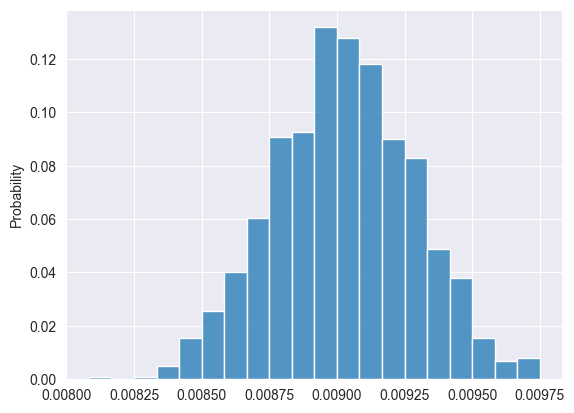

In [55]:
#We look at the codebook to check whether or not it ressembles a normal distribution around 0.

norms = []

#Uncomment the code below to get a graph of how the freshly initialized codebook should look.
model.first_stage_model.quantize.embedding.weight.data.uniform_(-1.0/(model.first_stage_model.quantize.n_e),1/(model.first_stage_model.quantize.n_e))

for codebook in model.first_stage_model.quantize.parameters():
    for zq_codebook in codebook:
        norms += [np.linalg.norm(zq_codebook)]

#We know for a fact, that all norms will be equal to or less than 2 if it has just been instantiated
#assert(len([norm for norm in norms if norm>2])>0)

sb.histplot(norms,bins=20,stat="probability")